# Action Log Analysis



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

#retweet = "RT"
#mention = "MT"
#reply = "RE"

In [2]:
"""Read action log into a pandas dataframe"""

def dateparse (timestamp):    
    return datetime.datetime.fromtimestamp(float(timestamp))

log = pd.read_csv("./Data/higgs-activity_time.txt", delimiter=" ",
                  index_col="time", parse_dates=True, date_parser=dateparse)

print(log.shape[0])
log = log.loc[log["type"] != "RE"]
print(log.shape[0])
users = log["user2"].drop_duplicates()

#threshold = 5
#value_counts = log["user2"].value_counts()
##print(value_counts.head())
#to_remove = value_counts[value_counts <= threshold].index
#print("will remove: {}".format(len(to_remove)))
#print(to_remove[0])
#log = log.drop(to_remove)
#
#print(log.shape[0])
#        
print(log.head())


563069
526167
                      user1   user2 type
time                                    
2012-06-30 17:02:52  223789  213163   MT
2012-06-30 17:06:21  376989   50329   RT
2012-06-30 17:06:23   26375  168366   MT
2012-06-30 17:06:32  376989   13813   RT
2012-06-30 17:06:48  453850       8   RT


In [3]:
"""Split a dataset into n unequal time intervals"""

def split_dataset(df, n, tmin, timedeltas):
    """df must have date index, and timedeltas must stay in range"""
    
    splits = []
    
    _min = tmin
    _max = tmin + timedeltas[0]
    
    for i in range(1,n):
        split = df.truncate(before=_min, after=_max)
        splits.append(split)
        _min = _max
        _max = _max + timedeltas[i]
    
    split = df.truncate(before=_min, after=_max)
    splits.append(split)
        
    return splits

# Split dataset into periods I, II, III, IV 
num_periods = 4
tmin = log.index.min()
tmax = log.index.max()

t1 = 0.7
t2 = 0.9
t3 = 1.6
t4 = 3.7

s1 = t1
s2 = s1 + t2
s3 = s2 + t3
s4 = s3 + t4

timedeltas = [datetime.timedelta(days=t1),
                datetime.timedelta(days=t2),
                datetime.timedelta(days=t3),
                datetime.timedelta(days=t4)]
splits = split_dataset(log, num_periods, tmin, timedeltas)

for i in range(num_periods):
    print("Split {} has {} actions".format(i, splits[i].shape[0]))
    print(splits[i].index.min(), splits[i].index.max())

print(log.tail())

Split 0 has 1437 actions
2012-06-30 17:02:52 2012-07-01 09:50:49
Split 1 has 7738 actions
2012-07-01 09:51:36 2012-07-02 07:26:52
Split 2 has 51205 actions
2012-07-02 07:26:52 2012-07-03 21:50:52
Split 3 has 465327 actions
2012-07-03 21:50:52 2012-07-07 14:38:32
                      user1  user2 type
time                                   
2012-07-07 16:58:50   97296  15483   MT
2012-07-07 16:59:12   19979  49694   MT
2012-07-07 16:59:12   19979  80429   MT
2012-07-07 16:59:34  178085   1062   RT
2012-07-07 16:59:53   23996    253   RT


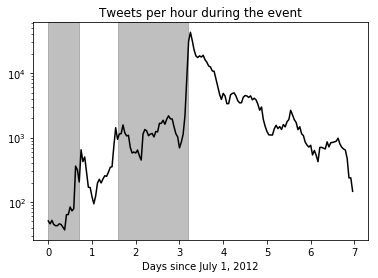

In [4]:
"""Make plot of tweets/hour"""

import matplotlib.dates as mdates

tmin = log.index.min()
tmax = log.index.max()

dt = datetime.timedelta(hours=1.0)
T = []
t = tmin
tweets_per_hour = []
while t < tmax:
    tweets_per_hour.append(log[t:t+dt].shape[0])
    T.append(t)
    t += dt
T = mdates.date2num(T); T = T - T[0]

(fig, ax) = plt.subplots()
ax.semilogy(T, tweets_per_hour, color="k")
ax.axvspan(0, s1, alpha=0.5, color='grey')
ax.axvspan(s2, s3, alpha=0.5, color='grey')
plt.title("Tweets per hour during the event")
plt.xlabel("Days since July 1, 2012")
plt.xticks(np.arange(8))
plt.show()



## Table 1: activities / period
| Period | #activities |
| ------------- |:-------------:|
| I      | 1617        |
| II     | 23132       |
| III    | 370195      |
| IV     | 131223      |


In [5]:
# Count occurences of users as (mentioned, retweeted, replied)

#print(log.shape[0])

users = log["user2"].drop_duplicates()
#print(users.shape[0])

counts = np.zeros((users.shape[0], num_periods), dtype=np.uint32)
user_index = np.zeros(users.shape[0], dtype=np.uint32)

first = True
for i in range(num_periods):
    print(i)
    split = splits[i]
    j = 0
    for user in users:
        if first:
            user_index[j] = user
        counts[j][i] = (split[split["user2"] == user]).shape[0]
        j += 1
    first = not first
        

0
1
2
3


In [6]:
print(counts[0:10, :])
print(user_index[0:10])

[[   2    0    2    0]
 [   4    1   27   18]
 [   1    0    0    0]
 [   5    4  131 1760]
 [  20   11  656  576]
 [   1    0    2    0]
 [   1    0    0    0]
 [   1    0    0   12]
 [   1   23    3   11]
 [   2    9   39  347]]
[213163  50329 168366  13813      8 364376 364375  60337  84647  42182]


In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

data = counts
#scaler = StandardScaler().fit(data)
#centered = scaler.transform(data)

num_clusters = 4

pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit(reduced_data)
print("fitted")


fitted


(4, 2)
[[  1.45967830e-02   1.04949277e-01   5.44552014e-01   5.29496318e+00]
 [  2.45013803e+01   5.97499174e+01   7.55977577e+02   7.88897442e+03]
 [  1.58167077e+02   4.37158983e+02   5.71566698e+03   2.83010371e+04]
 [  3.98948730e+00   1.00744465e+01   1.27809400e+02   1.15956259e+03]]
(59890, 2)
59890 users in cluster 0
(3, 2)
3 users in cluster 1
1988
(1, 2)
1 users in cluster 2
(83, 2)
83 users in cluster 3


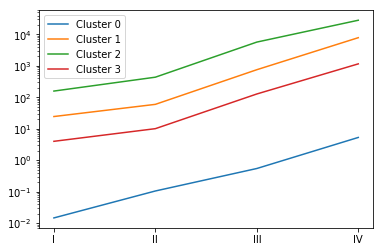

In [23]:
"""Describe clustering results"""

centroids = kmeans.cluster_centers_
print(centroids.shape)
i_centroids = pca.inverse_transform(centroids)
print(i_centroids)
#i_centroids = scaler.inverse_transform(i_centroids)
#print(i_centroids)

# Print centroids
clusters = []
for i in range(num_clusters):
    (c,) = np.where(kmeans.labels_ == i)
    print(reduced_data[c].shape)
    #c is row numbers in the reduced_data matrix ~ data_matrix = (59000, 4)
    clusters.append(c)
    num_in_cluster = len(c)
    print("{} users in cluster {}".format(num_in_cluster, i))
    if i == 1:
        print(user_index[c[1]])

# Plot centroids along time-axis
plt.figure(2)
handles = []
P = range(num_periods)
for i in range(num_clusters):
    h, = plt.semilogy(P, i_centroids[i,:], label="Cluster {}".format(i))
    handles.append(h)

plt.legend(handles=handles)
plt.xticks(P, ["I", "II", "III", "IV"])
plt.show()

(59977, 4)
(59890, 2)
58170 users in cluster 0
116 users in cluster 1
333 users in cluster 2
1271 users in cluster 3


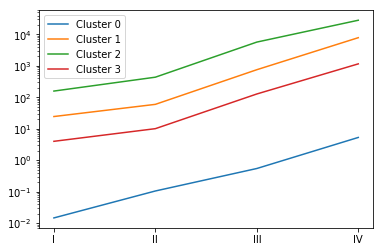

In [30]:
cl0_reduced_data = reduced_data[clusters[0]]

print(data.shape)
print(cl0_reduced_data.shape)

kmeans_cl0 = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)

kmeans_cl0.fit(cl0_reduced_data)

"""Describe clustering results"""

cl0_centroids = kmeans_cl0.cluster_centers_
cl0_i_centroids = pca.inverse_transform(cl0_centroids)
#print(i_centroids)
#i_centroids = scaler.inverse_transform(i_centroids)
#print(i_centroids)

# Print centroids
for i in range(num_clusters):
    (c,) = np.where(kmeans_cl0.labels_ == i)
    num_in_cluster = len(c)
    print("{} users in cluster {}".format(num_in_cluster, i))
#    if i == 1:
#        print(user_index[c[1]])

# Plot centroids along time-axis
plt.figure(3)
handles = []
P = range(num_periods)
for i in range(num_clusters):
    h, = plt.semilogy(P, i_centroids[i,:], label="Cluster {}".format(i))
    handles.append(h)

plt.legend(handles=handles)
plt.xticks(P, ["I", "II", "III", "IV"])
plt.show()


In [ ]:
"""Find a unique (cluster 1) user"""

averages = [0]*num_clusters

for i in range(1,num_clusters):

    users_in_cluster = user_index[np.where(kmeans.labels_ == i)]
    avg = 0.0
    for user in users_in_cluster:
        avg += (log[log["user2"] == user]).shape[0]
    avg /= len(users_in_cluster)
    averages[i] = avg
    
print(averages)

In [ ]:
"""Summarize the action log"""


def num_times_spread_by(u, v):
    return len([_ for a in action_log if a.u1 == u and a.u2 == v])

def num_times_spread(v):
    return len([a.u2 for a in action_log if a.u2 == v])

def num_followers(u):
    return len(list(G.predecessors(u)))

def num_following(u):
    return len(list(G.successors(u)))

for a in action_log[0:10]:
    a.print()

i=0
for u in G:
    if i < 10:
        print("user {} had influence {} times, has {} followers, and follows {} users".format(u, num_times_spread(u), num_followers(u), num_following(u)))
    i += 1

"""
Compute "Friendliness" of events
"""

activities_between_friends = 0
activities_between_strangers = 0

for a in action_log:
    if (G.has_edge(a.u1, a.u2) or G.has_edge(a.u2, a.u1)):
        activities_between_friends += 1
    else:
        activities_between_strangers += 1
        
print(activities_between_friends)
print(activities_between_strangers)

In [ ]:
"""
Read activity log into a list of actions
"""

retweet = "RT"
mention = "MT"
reply = "RE"

class Action:
    def __init__(self, u1, u2, t, kind):
        self.u1 = u1
        self.u2 = u2
        self.t = t
        self.kind = kind
    def print(self):
        verbs = {"RT" : "retweeted", "MT" : "mentioned", "RE" : "replied"}
        print("user {} was {} by user {} @ t = {}".format(self.u2, verbs[self.kind], self.u1, self.t))


action_log = []

with open("./Data/higgs-activity_time.txt", "r") as log:
    i=0
    for line in log:
        if i == 0: #skip header
            i+=1
            continue
            
        words = line.split(" ")
        u1 = int(words[0])
        u2 = int(words[1])
        if (u1 in G and u2 in G):
            t = int(words[2])
            kind = words[3].rstrip("\n")
            action = Action(u1, u2, t, kind)
            action_log.append(action)
        else: 
            print("Whoah!")

print(len(action_log))